# Generative Creation of Synthetic 3D Tumors in MRI Head Scans 🧠🧬✨

This notebook include the full code of creating synthetic 3D tumors in MRI head scans.

More info on repo: https://github.com/MoriahDavid/Synthetic-3D-Tumors

In [1]:
# Download MRI head file with it's label
!wget -q https://github.com/MoriahDavid/Synthetic-3D-Tumors/raw/refs/heads/main/data/MRHead.nrrd
!wget -q https://github.com/MoriahDavid/Synthetic-3D-Tumors/raw/refs/heads/main/data/MRHead-label.nrrd

In [2]:
%pip install elasticdeform pynrrd numpyencoder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.6/91.6 kB 2.5 MB/s eta 0:00:00


In [3]:
import nrrd

from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

def load_nrrd_volume(filename, to_pad=256):
  volume, header = nrrd.read(filename)
  print(volume.shape)

  if to_pad:
    x_pad = int((to_pad - volume.shape[0]) / 2)
    y_pad = int((to_pad - volume.shape[1]) / 2)
    z_pad = int((to_pad - volume.shape[2]) / 2)
    npad = ((x_pad, x_pad), (y_pad, y_pad), (z_pad, z_pad))

    volume = np.pad(volume, pad_width=npad, mode='constant', constant_values=0)

  return volume


def visualize_slice(ct_scan, slice_index):
    plt.imshow(ct_scan[:, :, slice_index], cmap='gray')

    plt.title(f'Slice at index {slice_index}')
    plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import elasticdeform


def generate_tumor(size, growth_stage, roughness=0.1, scaling_factors=(1.0, 1.0, 1.0),
                   noise_amplitude=0.2, opacity_distance=2,
                   min_color=0, max_color=255,
                   deform_x=1, deform_y=1, deform_z=1):
    """
    Generates a 3D model of a brain tumor with realistic shape deformations and grayscale values.

    Parameters:
        size (int): The size of the 3D grid.
        growth_stage (float): A value between 0 and 1 representing the tumor's growth stage (0 = early, 1 = fully grown).
        roughness (float): Controls the roughness or irregularity of the tumor surface.
        scaling_factors (tuple): Scaling factors along the (x, y, z) axes to deform the shape.
        noise_amplitude (float): The amplitude of random noise to perturb the surface.

    Returns:
        np.ndarray: A 3D numpy array representing the grayscale tumor.
    """

    # Create a 3D grid of coordinates
    x, y, z = np.meshgrid(np.linspace(-1, 1, size),
                          np.linspace(-1, 1, size),
                          np.linspace(-1, 1, size))

    # Apply scaling factors to distort the spherical shape
    x = x * scaling_factors[0]
    y = y * scaling_factors[1]
    z = z * scaling_factors[2]

    # Generate a basic spherical tumor
    sphere = np.sqrt(x**2 + y**2 + z**2)
    tumor_radius = 0.5 * growth_stage
    tumor = sphere <= tumor_radius

    # Add random noise to perturb the surface
    noise = np.random.normal(0, noise_amplitude, size=x.shape)
    rough_surface = np.random.normal(0, roughness, size=x.shape)
    tumor = tumor & ((sphere + rough_surface + noise) <= tumor_radius)

    # Smooth the tumor shape to make it more realistic
    tumor = gaussian_filter(tumor.astype(float), sigma=1) > 0.5

    # Generate grayscale values for the tumor
    distance_from_center = sphere * tumor

    max_distance = np.max(distance_from_center)
    print(f"max_distance: {max_distance}")
    print(f"min_distance: {np.min(distance_from_center)}")

    # Normalize grayscale values to range from 0 to 1
    grayscale_values = (1 - (distance_from_center) / (np.max(distance_from_center)))

    # Scale values to range from 0 to 192
    grayscale_values = grayscale_values * 100 + 30

    # Apply grayscale values, background remains 0
    tumor_grayscale = np.where(tumor, grayscale_values, 0).astype(np.uint8)

    # Create opacity values
    half_distance = max_distance / opacity_distance
    opacity_values = (1 - (distance_from_center - half_distance) / (np.max(distance_from_center) - half_distance))
    opacity_values[opacity_values > 1] = 1

    # deform the tumor shape
    if deform_x > 0:
      [tumor_grayscale, opacity_values] = elasticdeform.deform_random_grid([tumor_grayscale, opacity_values], sigma=deform_x, points=3, order=0, axis=(0, 1))
    if deform_y > 0:
      [tumor_grayscale, opacity_values] = elasticdeform.deform_random_grid([tumor_grayscale, opacity_values], sigma=deform_y, points=3, order=0, axis=(1, 2))
    if deform_z > 0:
      [tumor_grayscale, opacity_values] = elasticdeform.deform_random_grid([tumor_grayscale, opacity_values], sigma=deform_z, points=3, order=0, axis=(0, 2))


    return tumor_grayscale, opacity_values



In [5]:
import numpy as np
import nrrd
from scipy.ndimage import distance_transform_edt, gaussian_gradient_magnitude
from scipy.spatial import Delaunay
import random
from numpyencoder import NumpyEncoder
from scipy import ndimage


def replace_nonzero_subarray(original, replacement, center, opacity_mask=None):
    """
    Replaces only the non-zero values in the original 3D array with values from another 3D array
    starting from the given position.
    """
    start = np.array(center) - np.floor_divide(np.array(replacement.shape), 2)

    # Ensure that the replacement fits within the bounds of the original array
    if (start[0] + replacement.shape[0] > original.shape[0] or
        start[1] + replacement.shape[1] > original.shape[1] or
        start[2] + replacement.shape[2] > original.shape[2]):
        raise ValueError("Replacement array exceeds the bounds of the original array.")

    # Get the slice of the original array where the replacement will happen
    original_slice = original[start[0]:start[0] + replacement.shape[0],
                              start[1]:start[1] + replacement.shape[1],
                              start[2]:start[2] + replacement.shape[2]]

    # Replace only the non-zero values in the original slice
    mask = replacement != 0
    original_slice[mask] = ((opacity_mask[mask])*replacement[mask] + (1-opacity_mask[mask])*original_slice[mask])

    # Assign the modified slice back to the original array
    original[start[0]:start[0] + replacement.shape[0],
             start[1]:start[1] + replacement.shape[1],
             start[2]:start[2] + replacement.shape[2]] = original_slice

    return original



def insert_tumor_in_ct_scan(ct_scan_path, output_path, tumor_radius=10,
                            growth_stage=0.5, tumor_center=None,
                            roughness=0.1, scaling_factors=(1.0, 1.0, 1.0),
                            noise_amplitude=0.2,
                            opacity_distance=2,
                            deform_x=1, deform_y=1, deform_z=1):

    # Save the tumor options
    options = dict(locals())

    print(f'Reading CT scan from: {ct_scan_path}')
    brain_scan, header = nrrd.read(ct_scan_path)

    print(f'Generating tumor with radius: {tumor_radius}')
    min_color = np.amin(brain_scan)
    max_color = np.amax(brain_scan)
    tumor, opacity_mask = generate_tumor(tumor_radius, growth_stage, roughness,
                                         scaling_factors, noise_amplitude, opacity_distance,
                                         min_color, max_color,
                                         deform_x, deform_y, deform_z)

    if tumor_center is None:
        tumor_center = [s // 2 for s in brain_scan.shape]
        print(f'Tumor center set to: {tumor_center}')

    # place the tumor in the volume
    brain_scan_with_tumor = replace_nonzero_subarray(brain_scan, tumor,
                                                     tumor_center, opacity_mask)
    print(f'Writing output to: {output_path}')
    nrrd.write(output_path, brain_scan_with_tumor, header)
    print('Tumor insertion completed.')

    with open(output_path.replace('.nrrd', '.json'), 'w') as f:
        json.dump(options, f, cls=NumpyEncoder, indent=2)


In [6]:

def find_pixel(matrix, region='center', growth_radius=0):
    matrix = np.array(matrix)

    # Get indices of non-zero voxels
    non_zero_voxels = np.argwhere(matrix != 0)

    if region == 'center':
        # Calculate the mean of the non-zero voxels for "center" point
        center_voxel = np.mean(non_zero_voxels, axis=0)
        # Find the closest voxel to this center point
        closest_voxel = non_zero_voxels[np.argmin(np.linalg.norm(non_zero_voxels - center_voxel, axis=1))]
        return tuple(closest_voxel)

    elif region == 'edge':
        # Matrix dimensions
        depth, height, width = matrix.shape

        while True:
            # Randomly choose a non-zero voxel
            chosen_voxel = non_zero_voxels[random.randint(0, len(non_zero_voxels) - 1)]
            z, y, x = chosen_voxel

            # Calculate the minimum distance of the voxel from the edges
            distance_to_edge = min(z, depth - z - 1, y, height - y - 1, x, width - x - 1)

            # Check if the voxel's distance from the edge is greater than or equal to the growth_radius
            if distance_to_edge >= growth_radius:
                return tuple(chosen_voxel)

    else:
        raise ValueError("Region must be 'center' or 'edge'")


Fucntions for creating slice

In [7]:
import numpy as np
import math
import nrrd
from scipy.ndimage import map_coordinates
from matplotlib import pyplot as plt


def plane_line_intersection(plane, line, tol=1e-6):
    """
    Calculate the intersection point of a plane (defined by 3 points)
    and a line (defined by 2 points).

    :param plane: A NumPy array with 3 3D points representing a plane.
    :param line:  A NumPy array with 2 3D points representing a line.
    :param tol: Tolerance to check for parallelism (default: 1e-6).
    :return: The intersection point as a NumPy array or None if no intersection exists (parallel line).
    """
    p1, p2, p3 = plane
    a, b = line
    # Calculate the normal vector of the plane (cross product of two vectors on the plane)
    plane_normal = np.cross(p2 - p1, p3 - p1)

    # Check if the normal vector is too small (plane is degenerate)
    if np.linalg.norm(plane_normal) < tol:
        raise ValueError("The points defining the plane are collinear or too close together.")

    # Direction vector of the line
    line_dir = b - a

    # Check if the line is parallel to the plane
    denom = np.dot(plane_normal, line_dir)

    if abs(denom) < tol:
        print("The line is parallel to the plane, no intersection.")
        return None

    # Calculate the parameter t for the line equation
    t = np.dot(plane_normal, (p1 - a)) / denom

    # Calculate the intersection point
    intersection_point = a + t * line_dir

    return intersection_point


def perpendicular_line(p, line):
    """
    Calculate the perpendicular line from point P to a line defined by 2 points.
    The return value is a line defined by two points: P and the closest point on the line.

    :param p: The point P (as a NumPy array) where the perpendicular line passes through.
    :param line:  A NumPy array with 2 3D points representing a line.
    :return: A tuple containing two points (P, closest_point_on_line) that define the perpendicular line.
    """
    a, b = line
    # Direction vector of the original line AB
    ab = b - a

    # Vector from point A to point P
    ap = p - a

    # Normalize the direction vector
    ab_normalized = ab / np.linalg.norm(ab)

    # Projection of AP onto the direction vector AB
    projection_length = np.dot(ap, ab_normalized)

    # Closest point on the line AB to the point P
    closest_point_on_line = a + projection_length * ab_normalized

    # Return the perpendicular line as two points: P and the closest point on the original line
    return p, closest_point_on_line


def line_intersection(line1, line2, tol=1e-6):
    """
    Calculate the intersection point of two lines in 3D space, defined by two points on each line.

    :param line1: A NumPy array with 2 3D points representing a line.
    :param line2: A NumPy array with 2 3D points representing the second line.
    :param tol: Tolerance to check if lines are parallel or skew (default: 1e-6).
    :return: The intersection point as a NumPy array or None if no intersection exists.
    """
    p1, p2 = line1
    q1, q2 = line2
    # Direction vectors of the lines
    d1 = p2 - p1  # Direction of line 1
    d2 = q2 - q1  # Direction of line 2

    # Normalize the direction vectors
    d1 = d1 / np.linalg.norm(d1)
    d2 = d2 / np.linalg.norm(d2)

    # Cross product of direction vectors
    cross_d1_d2 = np.cross(d1, d2)

    # Check if lines are parallel (cross product is close to zero vector)
    if np.linalg.norm(cross_d1_d2) < tol:
        print("Lines are parallel or coincident.")
        return None

    # Vector between points on the two lines
    p1q1 = q1 - p1

    # Solving for t1 and t2 using the system of equations derived from parametric form
    A = np.array([d1, -d2, cross_d1_d2]).T
    if np.linalg.matrix_rank(A) < 3:
        print("Lines are skew and do not intersect.")
        return None

    t_vals = np.linalg.solve(A, p1q1)

    # Calculate the intersection point using parameter t1 (from line 1)
    intersection_point = p1 + t_vals[0] * d1

    return intersection_point


def get_box_planes(min=0, max=255):
    """
    Returns the 6 box planes in 3D space.
    """
    plane_1 = np.array(((min, min, min), (min, 120, max), (min, max, min)))
    plane_2 = np.array(((max, min, min), (max, 120, max), (max, max, min)))
    plane_3 = np.array(((min, max, min), (120, max, max), (max, max, min)))
    plane_4 = np.array(((min, min, min), (120, min, max), (max, min, min)))
    plane_5 = np.array(((max, max, max), (120, min, max), (min, max, max)))
    plane_6 = np.array(((min, max, min), (120, min, min), (max, max, min)))

    return [plane_1, plane_2, plane_3, plane_4, plane_5, plane_6]


def find_cut_plane_of_line(line, planes):
    """
    Finds the two planes that cut the given line.

    :param line: A NumPy array with 2 3D points representing a line.
    :param planes: List of planes to find a cut for.
    :return: A list of planes that cut the line.
    """
    results = []
    for plane in planes:
        r = plane_line_intersection(plane, line)
        if r is not None:
            r = np.round(r,3)
        if r is None or min(r) < 0 or max(r) > 255:
            continue
        results.append(r)

    return np.unique(results, axis=0) # use unique to remove duplicates


def get_slice(volume, p1, p2, p3):
    """
    Slice a 3D volume at a given plane defined by three points.
    """
    # Calc dist all points
    d12 = math.dist(p1, p2)
    d13 = math.dist(p1, p3)
    d23 = math.dist(p2, p3)

    # Get the max dist and points
    max_p = max([(d12, p1, p2, p3), (d13, p1, p3, p2), (d23, p2, p3, p1)], key=lambda item: item[0])

    # Set p1 and p2 to the max dist, p3 is the third point
    d12, p1, p2, p3 = max_p

    # calculate the perpendicular_line from p3 to the line of p1 and p2
    l1 = (p1, p2)
    # using perpendicular_line() method
    l2 = perpendicular_line(p3, l1)

    box_planes = get_box_planes()

    # calculate the dist between p3 and the cut to the line of p1 and p2
    p_cut_l1_l2 = line_intersection(l1, l2)

    p3_1, p3_2 = find_cut_plane_of_line(l2, box_planes)
    p3, p4 = max((p3_1, p3_2), (p3_2, p3_1), key=lambda item: math.dist(item[0], p_cut_l1_l2))

    d_p3_l1 = math.dist(p_cut_l1_l2, p3)

    p1, p2 = find_cut_plane_of_line(l1, box_planes)
    d12 = math.dist(p1, p2)

    width = round(d12)
    height = round(d_p3_l1)
    back_height = round(math.dist(p4, p_cut_l1_l2))

    delta_back_height = (p4 - p_cut_l1_l2) / back_height
    delta_width = (p2 - p1) / width
    delta_height = (p3 - p_cut_l1_l2) / height

    slice = []

    p1 = p1 + delta_back_height * back_height

    j_values = np.arange(height + back_height)[:, None]  # Shape: (height+back_height, 1)
    i_values = np.arange(width)  # Shape: (width,)

    # Create meshgrid for i and j (index grids)
    i_mesh, j_mesh = np.meshgrid(i_values, j_values)  # Shape: (height+back_height, width)

    # Reshape i_mesh and j_mesh to broadcast correctly with 3D vectors
    i_mesh_3d = i_mesh[:, :, None]  # Shape: (height+back_height, width, 1)
    j_mesh_3d = j_mesh[:, :, None]  # Shape: (height+back_height, width, 1)

    # Compute all points in a vectorized manner
    slice = p1 + i_mesh_3d * delta_width + j_mesh_3d * delta_height

    splited_coordinates = [slice[:, :, 0], slice[:, :, 1], slice[:, :, 2]]
    plane_slice = map_coordinates(volume, splited_coordinates, order=3, mode='constant', cval=0)

    return plane_slice


In [8]:
import os
import json
import datetime
import csv
import numpy as np
import cv2


def show_images_in_grid(slices, rows, cols):
    """
    Display a list of images in a grid (matrix) layout.

    :param slices: List of 2D arrays representing the images.
    :param rows: Number of rows in the grid.
    :param cols: Number of columns in the grid.
    """
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

    # Iterate over the images and the axes to plot them
    for i, ax in enumerate(axs.flat):
        if i < len(slices):
            ax.imshow(slices[i], cmap='gray')
            ax.set_title(f"{i}")
        ax.axis('off')  # Turn off axis

    plt.tight_layout()
    plt.show()


def center_and_resize_image(image: np.ndarray, output_size: tuple):
    image = np.pad(image, ((1,1), (1,1)))
    # Define black pixel value for grayscale images
    black_pixel = 0

    # Find non-black pixels
    non_black_pixels = np.where(image != black_pixel)

    if len(non_black_pixels[0]) == 0 or len(non_black_pixels[1]) == 0:
        # Handle case where the image is fully black
        return np.zeros(output_size, dtype=image.dtype)

    # Get bounding box for non-black pixels
    top, left = np.min(non_black_pixels[0]), np.min(non_black_pixels[1])
    bottom, right = np.max(non_black_pixels[0]), np.max(non_black_pixels[1])

    # Crop the image to the bounding box
    cropped_image = image[top:bottom+1, left:right+1]

    # Get the dimensions of the cropped image
    cropped_height, cropped_width = cropped_image.shape[:2]

    # Determine the scaling factor to fit the cropped image inside the output_size
    scale = min(output_size[0] / cropped_height, output_size[1] / cropped_width)

    # Resize the cropped image while keeping the aspect ratio
    new_height = int(cropped_height * scale)
    new_width  = int(cropped_width * scale)
    resized_image = cv2.resize(cropped_image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Create a new black canvas of the required output size
    output_image = np.zeros(output_size, dtype=image.dtype)

    # Compute center position for the resized image
    start_y = (output_size[0] - new_height) // 2
    start_x = (output_size[1] - new_width) // 2

    # Place the resized image in the center of the output image
    output_image[start_y:start_y+new_height, start_x:start_x+new_width] = resized_image

    return output_image


def save_slice_as_image(slice, filename):
  with open(filename, 'wb') as f:
    plt.imshow(slice, cmap='gray')
    plt.axis('off')
    plt.savefig(f, bbox_inches='tight', pad_inches=0)
    plt.close()


def save_slices(slices, folder, basename='slice'):
  metadata = []
  for i, slice in enumerate(slices):
    file_path = os.path.join(folder, f'{basename}_{i}.png')
    save_slice_as_image(slice["img"], file_path)
    metadata.append({"index": i, "points": slice["points"], "file_path": file_path})

  # Create metadata csv file
  with open(os.path.join(folder, 'metadata.csv'), 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, metadata[0].keys())
    writer.writeheader()
    writer.writerows(metadata)


In [9]:
def generate_random_slices(volume, number, center_point=None, normilize_image_size=(250,250)):
  slices = []

  for i in range(number):
    p1 = np.random.randint(low=0, high=(255, 120, 255))
    p2 = np.random.randint(low=0, high=(255, 120, 255))
    if center_point is not None:
      p3 = np.array(center_point)
    else:
      p3 = np.random.randint(low=0, high=(255, 120, 255))

    s = get_slice(volume, p1, p2, p3)
    s = center_and_resize_image(s, (250, 250))
    slices.append({"img":s, "points":[p1.tolist(), p2.tolist(), p3.tolist()]})

  return slices


## Generate the MRI scan with a tumor

In [14]:
org_mri_scan_path = '/content/MRHead.nrrd'
mask_mri_scan_path = org_mri_scan_path.replace('.nrrd', '-label.nrrd')

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
dest_mri_scan_name = os.path.basename(org_mri_scan_path).replace('.nrrd', f'-tumor-{timestamp}')

dest_folder = f'/content/{dest_mri_scan_name}'
os.makedirs(dest_folder, exist_ok=True)
dest_mri_scan_path = os.path.join(dest_folder, f'{dest_mri_scan_name}.nrrd')

radius = 50
growth_stage = 0.9
scaling_factors = (1.1, 1.6, 1.)
roughness = 0.3
noise_amplitude = 0.1
opacity_distance = 2
deform_x=0
deform_y=2
deform_z=2

brain_scan_mask, header = nrrd.read(mask_mri_scan_path)
tumor_center_pixel = find_pixel(brain_scan_mask, 'edge', radius)
print("center: ", tumor_center_pixel)

insert_tumor_in_ct_scan(org_mri_scan_path, dest_mri_scan_path,
                        tumor_radius=radius,
                        growth_stage=growth_stage,
                        tumor_center=tumor_center_pixel, # y, x, z
                        roughness=roughness,
                        scaling_factors=scaling_factors,
                        noise_amplitude=noise_amplitude,
                        opacity_distance=opacity_distance,
                        deform_x=deform_x, deform_y=deform_y, deform_z=deform_z)


center:  (155, 120, 56)
Reading CT scan from: /content/MRHead.nrrd
Generating tumor with radius: 50
max_distance: 0.4249457911872174
min_distance: 0.0
Writing output to: /content/MRHead-tumor-20241026_201121/MRHead-tumor-20241026_201121.nrrd
Tumor insertion completed.


###Extract multiple slices from the brain with the tumor scan



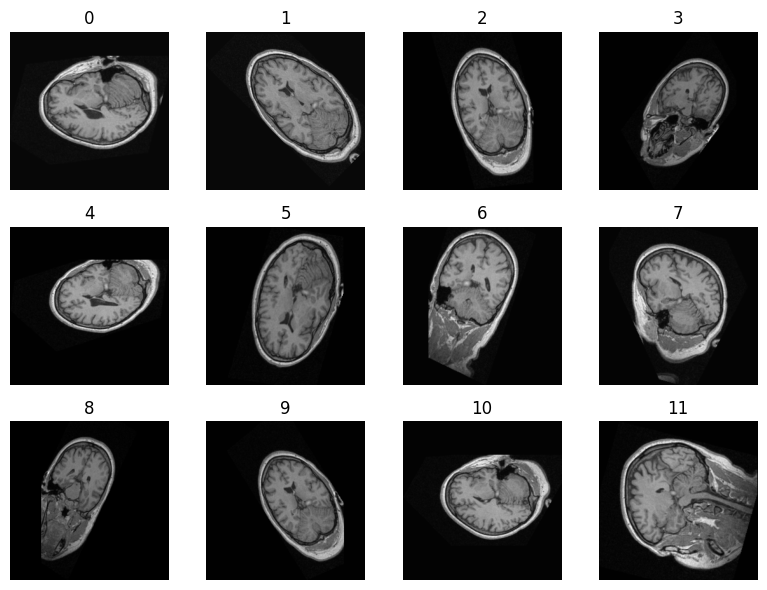

In [15]:
brain_scan, header = nrrd.read(dest_mri_scan_path)

slices_dest_folder = os.path.join(dest_folder, 'slices')
os.makedirs(slices_dest_folder, exist_ok=True)

slices = generate_random_slices(brain_scan, 12, tumor_center_pixel)

save_slices(slices, slices_dest_folder, dest_mri_scan_name)

# Display some of the images
show_images_in_grid([slice["img"] for slice in slices], 3, 4)

Create clean images of the same planes using the metadata file

In [16]:
points = []
with open(os.path.join(dest_folder, 'slices', 'metadata.csv'), newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        points.append(row['points'])

points_list = [np.array(eval(arr_str)) for arr_str in points]


In [17]:
brain_org, header = nrrd.read(org_mri_scan_path)
clean_folder = os.path.join(dest_folder, 'clean_slices')
os.makedirs(clean_folder, exist_ok=True)

slices = []
i = 0
for points in points_list:
  p1 = np.array(points[0])
  p2 = np.array(points[1])
  p3 = np.array(points[2])

  s = get_slice(brain_org, p1, p2, p3)
  s = center_and_resize_image(s, (250, 250))
  slices.append(s)
  i = i+1

  file_path = os.path.join(clean_folder, f'{os.path.basename(dest_folder)}_no_{i}.png')
  save_slice_as_image(s, file_path)



Create zip for downloading the results

In [ ]:
%cd /content/{dest_mri_scan_name}
!zip -r ../{dest_mri_scan_name}.zip *
%cd /content